# Prepare Data

In [2]:
import pandas as pd
import numpy as np
import pickle
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader, Batch
import time
import matplotlib.pyplot as plt
from datetime import datetime
import os

model_path = './models/'
data_path = './data/'

total num of edges:  921600


<function matplotlib.pyplot.show(*args, **kw)>

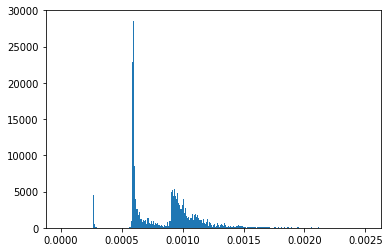

In [3]:
# first read in the fusion-graph
with open(data_path + 'fusion_graph.pickle', 'rb') as openfile:
    fusion_graph = pickle.load(openfile)
    
edge_list = []
for i in range(fusion_graph.shape[0]):
    for j in range(fusion_graph.shape[1]):
        edge_list.append(fusion_graph[i][j])
        
print('total num of edges: ', len(edge_list))

plt.hist(edge_list, bins=1000, range=(0.0, 0.0025))
plt.ylim((0, 30000))
plt.savefig('edge_weight_hist.png')
plt.show

In [3]:
# generate the Adjacency Matrix for the fusion graph (In COO format) and the list of edge weights
# here, we trim the edges that have edge weight below a certain threshold (current = 0.00111)
adj_row = []
adj_col = []
adj_data = []

TRIM_THRESHOLD = 0.00111

for i in range(fusion_graph.shape[0]):
    for j in range(fusion_graph.shape[1]):
        if fusion_graph[i][j] >= TRIM_THRESHOLD:
            adj_row.append(i)
            adj_col.append(j)
            adj_data.append(fusion_graph[i][j])
        
edge_index = torch.LongTensor([adj_row, adj_col])
edge_weight = torch.FloatTensor(adj_data)
edge_index.shape

torch.Size([2, 94100])

# Training

## Model Definition

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphConv(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super(GraphConv, self).__init__()
        
        self.dim_in = dim_in
        self.dim_out = dim_out

        # model definition
        self.conv = GCNConv(dim_in, dim_out, cached=False)
   
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        
        conv_feat = self.conv(x, edge_index, edge_weight=edge_weight)
        conv_feat_act = F.relu(conv_feat)
        
        return conv_feat_act

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.lstm = torch.nn.LSTM(input_dim, hid_dim, n_layers)
        
    def forward(self, input_tensor):
        
        # input_tensor shape = (sequence length, batch size, feature vector size)
        outputs, (hidden, cell) = self.lstm(input_tensor)
        
        return hidden, cell
    
class Decoder_Lin(torch.nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.lstm = torch.nn.LSTM(output_dim, hid_dim, n_layers)
        self.lin = torch.nn.Linear(64, 2)
        
    def forward(self, input_tensor, hidden, cell):
        
        # input_tensor shape = (sequence length, batch size, feature vector size)
        output, (hidden, cell) = self.lstm(input_tensor, (hidden, cell))
        output = self.lin(output[-1, :, :])
        # output = F.relu(output)
        
        return output, hidden, cell
    
class FC(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super(FC ,self).__init__()
        
        # now we are just picking numbers arbitrarily
        # could use some improvement
        self.fc1 = torch.nn.Linear(dim_in, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, dim_out)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

## Support Funcitons


In [6]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
def train(graph_conv, encoder, decoder, fc, optim_gcn, optim_encoder, optim_decoder, optim_fc, criterion, loader, is_training_pred=False):   
    graph_conv.train()
    encoder.train()
    decoder.train()
    fc.train()
 
    epoch_loss = 0
    
    num_batch = len(loader)

    for batch in loader:
        batch.to(device)
        y = batch.y.view(-1, NUM_NODE, 2)
        batch_weather = batch.target_weather.view(-1, NUM_WEATHER_FEATURE)
        
        # GCN
        conv_out = graph_conv(batch)
        batch = None # release memory
        
        # prepare data for encoder-decoder
        # pad first (WINDOW_SIZE - 1) entries with zero
        pad = torch.zeros(WINDOW_SIZE - 1, NUM_NODE, EMB_DIM).to(device)        
        
        time_steps = torch.cat((pad, conv_out.view(-1, NUM_NODE, EMB_DIM)), 0)
        
        # generate data in a sliding window manner
        encoder_in = torch.Tensor().to(device)
        target = torch.Tensor().to(device)
        weather = torch.Tensor().to(device)
        
        for i in range(time_steps.shape[0] - WINDOW_SIZE + 1):
            encoder_in = torch.cat((encoder_in, time_steps[i:i + WINDOW_SIZE, :, :]), 1)
            target = torch.cat((target, y[i, :, :]), 0)
            
            # tiling weather data
            weather = torch.cat((weather, batch_weather[i, :].repeat(NUM_NODE)))
        
        
        if is_training_pred is True:
            hidden, cell = encoder(encoder_in)
            
            # concat the final state of the LSTM
            cell_input = torch.cat((hidden.view(-1, 64), cell.view(-1, 64)), 1)
            
            # concat the weather data to the final state
            fc_input = torch.cat((cell_input, weather.view(-1, 18)), 1)

            # pass thru the FC layers
            fc_output = fc(fc_input)
            
            # backprop
            loss = torch.sqrt(criterion(fc_output, target))
            epoch_loss += loss.item()
            loss.backward(retain_graph=True)
            
            optim_gcn.step()
            optim_encoder.step()
            optim_fc.step()
        else:
            decoder_in = encoder_in[-DECODE_INTERVAL:, :, :]

            # ENCODER-DECODER
            hidden, cell = encoder(encoder_in)
            output, h_out, c_out = decoder(decoder_in, hidden, cell)

            # backprop
            loss = torch.sqrt(criterion(output, target))
            epoch_loss += loss.item()
            loss.backward(retain_graph=True)

            optim_gcn.step()
            optim_encoder.step()
            optim_decoder.step()
        
    return epoch_loss / num_batch

In [8]:
# nvidia-smi is showing reversed order
# GPU 1 is 'cuda:0' here
device = torch.device('cuda:0')

# HYPER_PARAM
NUM_NODE = 960
NUM_WINDOW = 10
WINDOW_SIZE = 6
EMB_DIM = 64
DECODE_INTERVAL = 3
LEARNING_RATE = 0.00001
ENCODER_DECODER_EPOCH  = 50
PREDICTION_EPOCH = 50
NUM_WEATHER_FEATURE = 18

with open(data_path + 'train_data_list.pickle', 'rb') as openfile:
    train_data_list = pickle.load(openfile)
    
print('# Num of training data: ', len(train_data_list))

# load dataset & weather data
loader = DataLoader(train_data_list, batch_size = WINDOW_SIZE * NUM_WINDOW)

# Model definition
graph_conv = GraphConv(2, EMB_DIM).to(device)
encoder = Encoder(EMB_DIM, EMB_DIM, 1).to(device)
decoder = Decoder_Lin(EMB_DIM, EMB_DIM, 1).to(device)
full_con = FC(EMB_DIM * 2 + NUM_WEATHER_FEATURE, 2).to(device)

optim_gcn = torch.optim.Adam(graph_conv.parameters(), lr=LEARNING_RATE)
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=LEARNING_RATE)
optim_fc = torch.optim.Adam(full_con.parameters(), lr=LEARNING_RATE)

# define loss
criterion = torch.nn.MSELoss() 

# Num of training data:  49414


In [ ]:
# Training the Encoder-Decoder
print('----- Training the Encoder-Decoder Network ----- \n')
encode_decode_losses = []
for epoch in range(ENCODER_DECODER_EPOCH):
    
    start_time = time.time()
    
    epoch_loss = train(graph_conv, encoder, decoder, full_con, optim_gcn, optim_encoder, optim_decoder, optim_fc, criterion, loader, is_training_pred=False)
        
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {(epoch_loss):.3f}')
    
    encode_decode_losses.append(epoch_loss)

    
# Training the Prediction Network
print('\n ----- Training the Prediction Network ----- \n')
pred_losses = []
for epoch in range(PREDICTION_EPOCH):
    
    start_time = time.time()
    
    epoch_loss = train(graph_conv, encoder, decoder, full_con, optim_gcn, optim_encoder, optim_decoder, optim_fc, criterion, loader, is_training_pred=True)
        
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {(epoch_loss):.3f}')
    
    pred_losses.append(epoch_loss)
    
torch.save(graph_conv.state_dict(), model_path + 'graph_conv.pt')
torch.save(encoder.state_dict(), model_path + 'encoder.pt')
torch.save(decoder.state_dict(), model_path + 'decoder.pt')
torch.save(full_con.state_dict(), model_path + 'fc.pt')

----- Training the Encoder-Decoder Network ----- 

Epoch: 01 | Time: 3m 3s
	Train Loss: 3.852
Epoch: 02 | Time: 3m 5s
	Train Loss: 3.481
Epoch: 03 | Time: 3m 7s
	Train Loss: 3.289
Epoch: 04 | Time: 3m 8s
	Train Loss: 3.140
Epoch: 05 | Time: 3m 18s
	Train Loss: 3.024
Epoch: 06 | Time: 3m 12s
	Train Loss: 2.939
Epoch: 07 | Time: 3m 16s
	Train Loss: 2.873
Epoch: 08 | Time: 3m 17s
	Train Loss: 2.816
Epoch: 09 | Time: 3m 10s
	Train Loss: 2.770
Epoch: 10 | Time: 3m 7s
	Train Loss: 2.729
Epoch: 11 | Time: 3m 11s
	Train Loss: 2.692
Epoch: 12 | Time: 3m 12s
	Train Loss: 2.661
Epoch: 13 | Time: 3m 9s
	Train Loss: 2.632
Epoch: 14 | Time: 3m 10s
	Train Loss: 2.606
Epoch: 15 | Time: 3m 12s
	Train Loss: 2.581
Epoch: 16 | Time: 3m 10s
	Train Loss: 2.558
Epoch: 17 | Time: 3m 9s
	Train Loss: 2.536
Epoch: 18 | Time: 3m 7s
	Train Loss: 2.517
Epoch: 19 | Time: 3m 8s
	Train Loss: 2.500
Epoch: 20 | Time: 3m 11s
	Train Loss: 2.484
Epoch: 21 | Time: 3m 8s
	Train Loss: 2.470
Epoch: 22 | Time: 3m 8s
	Train Loss

## Plot The Training Loss

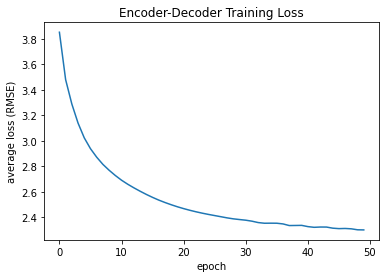

In [11]:
# Encoder-decoder training
x = np.arange(ENCODER_DECODER_EPOCH)

plt.plot(x, encode_decode_losses)
plt.title('Encoder-Decoder Training Loss')
plt.xlabel('epoch')
plt.ylabel('average loss (RMSE)')
plt.savefig('')
plt.show()

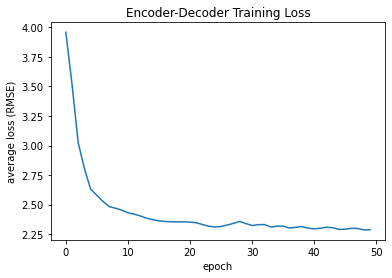

In [12]:
# Prediction network training
x = np.arange(PREDICTION_EPOCH)

plt.plot(x, pred_losses)
plt.title('Encoder-Decoder Training Loss')
plt.xlabel('epoch')
plt.ylabel('average loss (RMSE)')
plt.show()